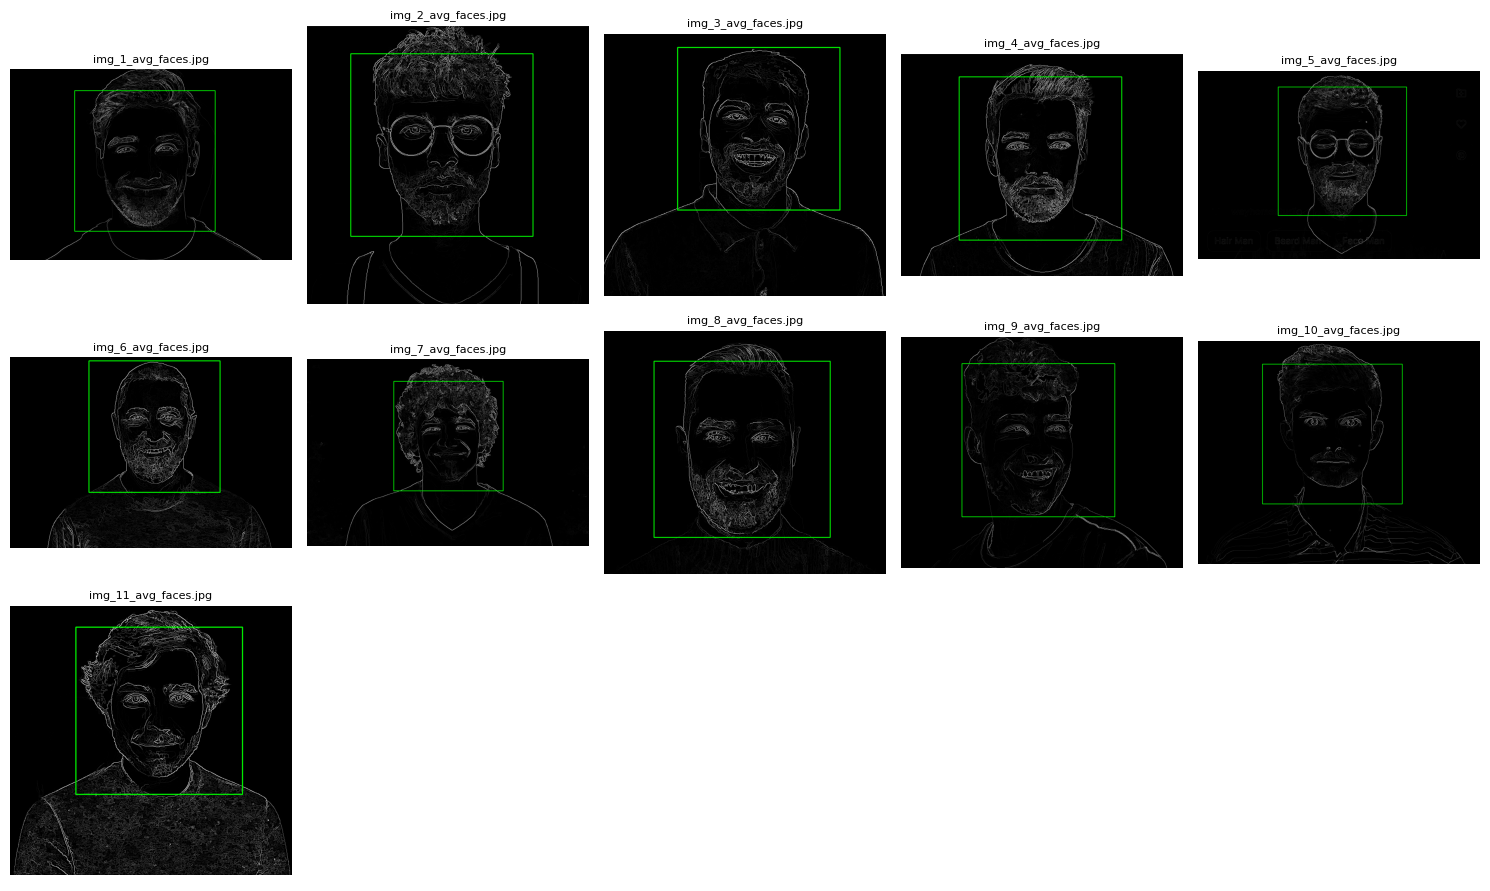

[[(255, 85, 555, 555)], [(136, 89, 568, 568)], [(205, 37, 453, 453)], [(189, 77, 530, 530)], [(353, 70, 566, 566)], [(235, 11, 391, 391)], [(360, 92, 454, 454)], [(156, 94, 551, 551)], [(246, 111, 618, 618)], [(288, 103, 625, 625)], [(168, 56, 426, 426)]]


In [12]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

bounding_boxes = []

def canny_edge_detection(input_folder, output_folder, threshold_pairs, cascade_path, padding=0):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the Haar Cascade Classifier for face detection
    face_cascade = cv2.CascadeClassifier(cascade_path)
    
    # Get list of all files in the input folder
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    processed_images = []

    # Process each file with each threshold pair
    for file_index, file in enumerate(files):
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        edge_images = []
        for i, (lower, upper) in enumerate(threshold_pairs):
            edges = cv2.Canny(img, lower, upper)
            edge_images.append(edges)
        
        # Average all edge detection results
        avg_edges = np.mean(edge_images, axis=0).astype(np.uint8)
        
        # Create a color image from the edges for better visualization
        avg_edges_color = cv2.cvtColor(avg_edges, cv2.COLOR_GRAY2BGR)

        # Draw bounding rectangles around detected faces on the edge-detected image
        padded_faces = []
        for (x, y, w, h) in faces:
            x_pad = max(x - padding, 0)
            y_pad = max(y - padding, 0)
            w_pad = min(w + 2 * padding, img.shape[1] - x_pad)
            h_pad = min(h + 2 * padding, img.shape[0] - y_pad)
            padded_faces.append((x_pad, y_pad, w_pad, h_pad))
            cv2.rectangle(avg_edges_color, (x_pad, y_pad), (x_pad + w_pad, y_pad + h_pad), (0, 255, 0), 2)
        
        bounding_boxes.append(padded_faces)

        # Save the average edge-detected image with bounding rectangles
        avg_output_filename = f"img_{file_index+1}_avg_faces.jpg"
        avg_output_path = os.path.join(output_folder, avg_output_filename)
        cv2.imwrite(avg_output_path, avg_edges_color)
        processed_images.append((avg_edges_color, avg_output_filename))

    # Plot the processed images in a grid with 5 columns
    num_images = len(processed_images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i, (img, title) in enumerate(processed_images):
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
        axes[i].set_title(title, fontsize=8)
        axes[i].axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
input_folder = 'inputs'
output_folder = 'outputs'
cascade_path = 'haarcascades/haarcascade_frontalface_default.xml'  # Path to Haar Cascade XML file

def generate_threshold_pairs(start, end, step):
    threshold_pairs = [(lower, upper) 
                       for lower in range(start, end, step) 
                       for upper in range(lower + step, end + step, step)]
    return threshold_pairs

threshold_pairs = generate_threshold_pairs(0, 250, 10)
padding = 60  # Set padding value here
canny_edge_detection(input_folder, output_folder, threshold_pairs, cascade_path, padding)
print(bounding_boxes)


In [1]:
import cv2
import numpy as np
from scipy.interpolate import splprep, splev

# List to store the points
points = []

# Mouse callback function to capture points
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print(f"Point {len(points)}: ({x}, {y})")
        if len(points) == 10:
            cv2.destroyWindow("Image")

def draw_smooth_curve(image, points):
    # Convert points to numpy array
    points = np.array(points, dtype=np.float32)
    
    # Interpolate points using B-spline
    tck, u = splprep([points[:,0], points[:,1]], s=0)
    unew = np.linspace(0, 1.0, 100)
    out = splev(unew, tck)
    
    # Convert interpolated points to integer values
    curve_points = np.column_stack((out[0], out[1])).astype(np.int32)
    
    # Draw the smooth curve
    for i in range(len(curve_points) - 1):
        cv2.line(image, tuple(curve_points[i]), tuple(curve_points[i+1]), (0, 255, 0), 2)

def main(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not open or find the image.")
        return

    # Create a window and set the mouse callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", mouse_callback)

    # Display the image and wait for points to be selected
    print("Click on 5 points in the image")
    while len(points) < 10:
        cv2.imshow("Image", image)
        cv2.waitKey(1)

    # Draw the smooth curve
    draw_smooth_curve(image, points)

    # Display the final image
    cv2.imshow("Output Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image
    output_path = "output_image.jpg"
    cv2.imwrite(output_path, image)
    print(f"Output image saved as {output_path}")

if __name__ == "__main__":
    image_path = input("Enter the path to the image: ")
    main(image_path)


Click on 5 points in the image
Point 1: (309, 191)
Point 2: (291, 271)
Point 3: (300, 341)
Point 4: (331, 403)
Point 5: (378, 448)
Point 6: (457, 455)
Point 7: (507, 405)
Point 8: (535, 344)
Point 9: (544, 259)
Point 10: (535, 189)
Output image saved as output_image.jpg
